In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [2]:
from google.colab import files
uploaded = files.upload()

Saving hungary_chickenpox.csv to hungary_chickenpox.csv


In [3]:
import io
dataset =pd.read_csv(io.BytesIO(uploaded["hungary_chickenpox.csv"]))
df = pd.DataFrame(dataset)
df.head()


,Date,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,HEVES,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
0,03/01/2005,168,79,30,173,169,42,136,120,162,36,130,57,2,178,66,64,11,29,87,68
1,10/01/2005,157,60,30,92,200,53,51,70,84,28,80,50,29,141,48,29,58,53,68,26
2,17/01/2005,96,44,31,86,93,30,93,84,191,51,64,46,4,157,33,33,24,18,62,44
3,24/01/2005,163,49,43,126,46,39,52,114,107,42,63,54,14,107,66,50,25,21,43,31
4,31/01/2005,122,78,53,87,103,34,95,131,172,40,61,49,11,124,63,56,7,47,85,60


[[168  79]
 [157  60]
 [ 96  44]
 [163  49]
 [122  78]
 [174  76]
 [153 103]
 [115  74]
 [119  86]
 [114  81]]
522


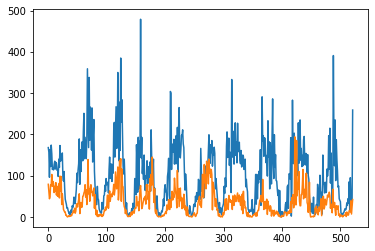

In [8]:
# The time records were taken in every 7 days
idx = np.array([])
seq_len =10

training_set_1 = dataset.iloc[:,1:3].values #include 2 features
#training_set_2 = dataset.iloc[:,2:3].values
print(training_set_1[0:10]) #this is numpy.ndarray
#training_set = []
print(len(training_set_1))
plt.plot(training_set_1, label = 'budapest')
#plt.plot(training_set_2[:], label = 'baranya')
plt.show()

In [ ]:
sc = MinMaxScaler()
traindata = sc.fit_transform(training_set_1)
input_x = []
 
for i in range(len(dataset)-seq_len-1):
    input_1 = traindata[i:(i+seq_len)]
    input_x.append(input_1.astype(float))
    
input_x = np.array(input_x)   
input=torch.tensor(input_x)
print(input.shape)

In [ ]:
#from numpy import array,hstack
#out_seq = array([input_x[i]+input_y[i] for i in range(len(input_x))])
#print(out_seq.shape)
#input_x = input_x.reshape((len(input_x), 1))
#input_y = input_y.reshape((len(input_y), 1))
#out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
#dataset = hstack((input_x, input_y, out_seq))
#print(out_seq[1:10])

In [21]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
    
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        print(input_size)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):

        h0x = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))# (num_layer,batch,hidden size)
        
        c0x = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        out, (h_out_x, _) = self.lstm(x, (h0x, c0x))
        #h_out_x = h_out_x.view(-1, self.hidden_size)
        out_1 = self.fc(out)
        return out_1

In [ ]:
#class MV_LSTM(torch.nn.Module):
#    def __init__(self,input_size,seq_len):
#        super(MV_LSTM, self).__init__()
#        self.n_features = input_size
#        self.seq_len = seq_len
#        self.n_hidden = 20 # number of hidden states
#        self.n_layers = 1 # number of LSTM layers (stacked)
    
#        self.l_lstm = torch.nn.LSTM(input_size = input_size, 
#                                 hidden_size = self.n_hidden,
#                                 num_layers = self.n_layers, 
#                                 batch_first = True)
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
#        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, 1)
        
    
#    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
#        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
#        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
#        self.hidden = (hidden_state, cell_state)
    
    
#    def forward(self, x):        
#        batch_size, seq_len, _ = x.size()
        
#        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
#        x = lstm_out.contiguous().view(batch_size,-1)
#        return self.l_linear(x)

In [ ]:
BATCH_SIZE=20 
batch = int(len(input)/BATCH_SIZE)
print(batch)
input_size = 2
hidden_size = 2
num_layers = 1
seq_len = 10
num_classes = 2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
loss_function = nn.MSELoss()

optimizer = optim.Adam(lstm.parameters(), lr=0.0005)#todo
for epoch in range(500):
    running_loss = 0.0
    for i in range(batch):
        input = input.float()
        input_batch = input[i:i+BATCH_SIZE]
        
        optimizer.zero_grad()
        output_x=lstm(input_batch.float())   
   
        loss = loss_function(output_x,input_batch) 
        loss.backward()
        
        optimizer.step()#update the weights
        optimizer.zero_grad()
        
         # print statistics
        running_loss +=loss
        if i % BATCH_SIZE == 0:    # print every 20 mini-batches
           print('[%d,%5d] loss: %.3f' %(epoch + 1, i + 1, running_loss))
 #finished training 

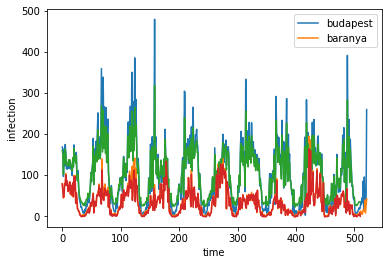

In [60]:

output = lstm(input)
data_predict_1 = output[:,0].data.numpy()
data_predict_2 = output[:,1].data.numpy()

data_predict_1 = sc.inverse_transform(data_predict_1)
data_predict_2 = sc.inverse_transform(data_predict_2)
plt.plot(training_set_1[:,0], label = 'budapest')
plt.plot(training_set_1[:,1], label = 'baranya')
plt.plot(data_predict_1[:,0],)
plt.plot(data_predict_1[:,1])
plt.xlabel('time')
plt.ylabel('infection')
plt.legend()
plt.show()